In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
fondo_a = pd.read_csv("/content/drive/My Drive/Crisis_BG_Fondo_A_agrupado.csv")['Fondo Tipo A']
#fondo_a = pd.read_csv("/content/drive/My Drive/Simulacion_intermedia_BG_Fondo_A_agrupado.csv")['Fondo Tipo A']
#fondo_a = pd.read_csv("/content/drive/My Drive/Forecast_Fondo_A_LSTM_agrupado_nuevo.csv")['Fondo Tipo A']
#fondo_a = pd.read_csv("/content/drive/My Drive/Forecast_Fondo_A_LSTM_agrupado.csv")['Fondo Tipo A']
#fondo_e = pd.read_csv("/content/drive/My Drive/Forecast_Fondo_E_RandomForest_agrupado.csv")['Fondo Tipo E']
fondo_e= pd.read_csv("/content/drive/My Drive/Crisis_BG_Fondo_E_agrupado.csv")['Fondo Tipo E']
#fondo_e= pd.read_csv("/content/drive/My Drive/Simulacion_intermedia_BG_Fondo_E_agrupado.csv")['Fondo Tipo E']
#fondo_e = pd.read_csv("/content/drive/My Drive/Forecast_Fondo_E_RandomForest_agrupado_nuevo.csv")['Fondo Tipo E']
fondo_a_historico=pd.read_csv("/content/drive/My Drive/Agrupacion_historica_Fondo_A.csv")[['Fondo Tipo A']]
fondo_e_historico=pd.read_csv("/content/drive/My Drive/Agrupacion_historica_Fondo_E.csv")[['Fondo Tipo E']]
fondo_a_mean=float(fondo_a.mean())
fondo_e_mean=float(fondo_e.mean())
periodos=40
covarianza = np.cov(np.stack((fondo_a.loc[:periodos].dropna().values,fondo_e.loc[:periodos].dropna().values),axis=0))
lambda_= fondo_a.values
mu_= fondo_e.values

In [ ]:
fondo_a_new=pd.DataFrame(fondo_a,columns=['Fondo Tipo A'])
fondo_e_new=pd.DataFrame(fondo_e,columns=['Fondo Tipo E'])
fondo_a_historico=pd.concat([fondo_a_historico,fondo_a_new],axis=0)
fondo_e_historico=pd.concat([fondo_e_historico,fondo_e_new],axis=0)

In [ ]:
fondo_a_historico=fondo_a_historico.reset_index().drop(columns=['index'])
fondo_e_historico=fondo_e_historico.reset_index().drop(columns=['index'])

In [ ]:
fondo_a_historico=fondo_a_historico['Fondo Tipo A']
fondo_e_historico=fondo_e_historico['Fondo Tipo E']

In [ ]:
fondo_a_mean

0.014003824345070096

In [ ]:
fondo_a.var()

0.08361806765156023

In [ ]:
fondo_e_mean

0.002458166588050148

In [ ]:
fondo_e.var()

0.0009969225645942972

In [ ]:
offset=19

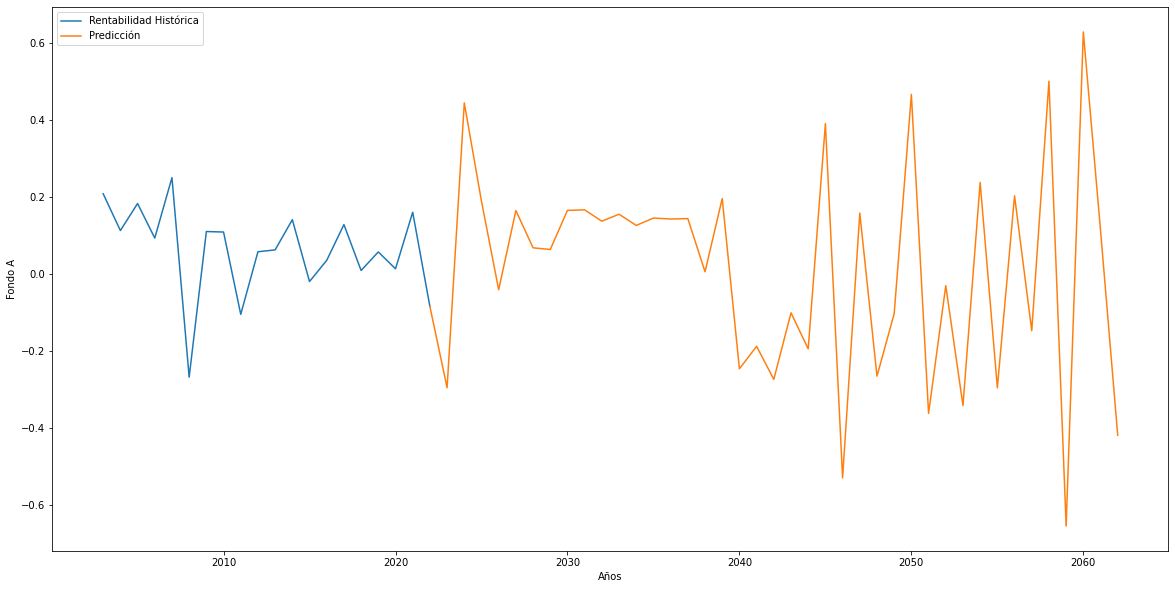

In [ ]:
plt.figure(figsize=(20,10))
plt.plot([2002+i for i in range(1,offset+2)],fondo_a_historico.loc[:offset],label='Rentabilidad Histórica')
plt.plot([2022+i for i in range(41)],fondo_a_historico[offset:],label='Predicción')
plt.legend()
#plt.plot(np.zeros(40))
plt.ylabel("Fondo A")
plt.xlabel("Años")
plt.show()

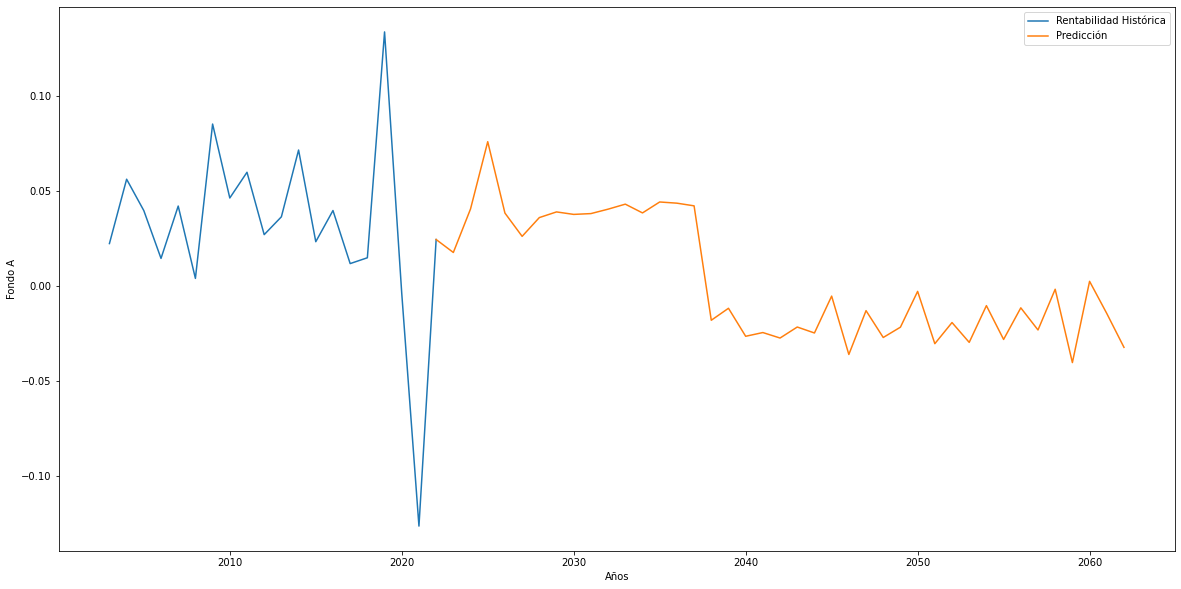

In [ ]:
plt.figure(figsize=(20,10))
plt.plot([2002+i for i in range(1,offset+2)],fondo_e_historico.loc[:offset],label='Rentabilidad Histórica')
plt.plot([2022+i for i in range(41)],fondo_e_historico[offset:],label='Predicción')
#plt.plot(np.zeros(40))
plt.legend()
plt.ylabel("Fondo A")
plt.xlabel("Años")
plt.show()

In [ ]:
!pip install gurobipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 27.4 MB/s 


In [ ]:
from gurobipy import *
from gurobipy import GRB

$$\max \mathbb{E}(R_p)-\gamma\operatorname{Var}(R_p)$$
Sujeto a 
$$\sum_{i=1}^2x_i=1$$
$$\mathbb{E}(R_p)\geq 0.05$$

Tenemos que 
$$\mathbb{E}(R_p)=\mathbb{E}(x_te^{\lambda_t}+(1-x_t)e^{\mu_t})=x_te^{\lambda+\sigma_1^2/2}+(1-x_t)e^{\mu+\sigma_2^2/2}$$

Por otro lado 
$$\operatorname{Var}(R_p)=\operatorname{Var}(x_te^{\lambda_t}+(1-x_t)e^{\mu_t})=x_t^2\operatorname{Var}(e^{\lambda_t})+(1-x_t)^2\operatorname{Var}(e^{\mu_t})+2x_t(1-x_t) \operatorname{Cov}(e^{\lambda_t},e^{\mu_t})$$

Donde
$$\operatorname{Var}(e^{\lambda_t})=[e^{\sigma_1^2}-1]e^{2\lambda+\sigma_1^2}$$
$$\operatorname{Var}(e^{\mu_t})=[e^{\sigma_2^2}-1]e^{2\mu+\sigma_2^2}$$
$$\operatorname{Cov}(e^{\lambda_t},e^{\mu_t})=e^{(\mu+\lambda)+(\sigma_1^2+\sigma_2^2)/2}[e^{\sigma_1\sigma_2\rho}-1]$$

Por lo tanto la función a maximizar es la siguiente
$$x_te^{\lambda+\sigma_1^2/2}+(1-x_t)e^{\mu+\sigma_2^2/2}-\gamma[x_t^2[e^{\sigma_1^2}-1]e^{2\lambda+\sigma_1^2}+(1-x_t)^2[e^{\sigma_2^2}-1]e^{2\mu+\sigma_2^2}+2x_t(1-x_t)e^{(\mu+\lambda)+(\sigma_1^2+\sigma_2^2)/2}[e^{\sigma_1\sigma_2\rho}-1]]$$

La restricción es 

$$x_te^{\lambda+\sigma_1^2/2}+(1-x_t)e^{\mu+\sigma_2^2/2}\geq e^{0.05}$$

La variable $\gamma$ nos entrega la aversión al riesgo del individuo, mientras más cercano a 0 es el valor de gamma tendremos mayor neutralidad al riesgo, pues estamos ignorando la desviación estándar y solo concentrandonos en el valor esperado

Modelo ALM considerando un pasivo como la contribucion (10%) del fondo fijo.

$$\max \mathbb{E}(R_p-R_L)-\gamma\operatorname{Var}(R_P-R_L)$$
Sujeto a 
$$\sum_{i=1}^2x_i=1$$
$$\mathbb{E}(R_p-R_L)\geq e^{0.005}$$

In [ ]:
offset=19

In [ ]:
for i in range(40):
  print(fondo_a_historico.loc[:i+offset].mean())

0.06368391682297933
0.04662358924483713
0.06474796743329365
0.0701819775446401
0.06559281069050699
0.06959561607602895
0.06956783203742177
0.0693821203274682
0.07283900703135213
0.07610180926915582
0.07816626770928396
0.08068318625869117
0.0821311685934667
0.08407329083595347
0.08582732778985121
0.08751107123620941
0.08526585563875314
0.08828197220850664
0.07950165024088077
0.07266915460031524
0.06402985478356885
0.060029468327860894
0.05398761046311102
0.06183611829910188
0.04841366007428989
0.05087222439609644
0.044018038102321515
0.04090393444538105
0.04979089930285774
0.041400004312127564
0.039985502965685385
0.032522039050748956
0.03648930948975242
0.030240042951274564
0.03345721522287784
0.030184151150819426
0.03860553529497616
0.026453065834878817
0.03685595904916063
0.038168402764156534


In [ ]:
for i in range(40):
  print(fondo_e_historico.loc[:i+offset].mean())

0.031054208488633068
0.030411176062404947
0.030868748352142806
0.03282624806949431
0.03305460633655938
0.032774136510702455
0.03289526362129588
0.03311801623216013
0.033278072006169016
0.03344180312365548
0.03367243474096744
0.03397320433538723
0.03411097992070286
0.0344149141134091
0.03468256158230168
0.03489474463580137
0.03342140077641667
0.032198233276196656
0.030651431326231125
0.029234254857795527
0.027815733415413723
0.02660790842320015
0.025382830003798533
0.02466633675877962
0.023283853786898293
0.022475619222291146
0.021395255883808556
0.020476548945897028
0.01998878565905955
0.0189586125268077
0.018192529136875274
0.017251689009979886
0.016718966178247436
0.015870656751619135
0.015361923271484558
0.014659635713572655
0.014365454853135276
0.013404036908540065
0.013213606617970074
0.012742702552749204


In [ ]:
x_solucion=np.ones(40)
alpha=np.exp(0.005)
f=np.zeros(41)
sueldo=1
c=0.1
f[0]=0.1
lista=[0.1,1,2,3,5,10,50]
x_vec=np.array([])
plt.figure(figsize=(20,10))
offset=19
f_vec_array=np.array([])
for gamma in lista:
  for i in range(40):
    m = Model('ALM')
    x = m.addVar(lb=0,ub=1,vtype=GRB.CONTINUOUS)
    #c=f[i]*0.1
    lambda_A_t=fondo_a_historico.loc[:i+offset].mean()#probar i-1
    sigma_A_t=fondo_a_historico.loc[:i+offset].var()
    mu_E_t=fondo_e_historico.loc[:i+offset].mean()
    sigma_E_t=fondo_e_historico.loc[:i+offset].var()
    m.addConstr(x*(np.exp(lambda_A_t+sigma_A_t/2))+(1-x)*(np.exp(mu_E_t+sigma_E_t/2))>=alpha)
    m.setObjective(x*float(np.exp(lambda_A_t+sigma_A_t/2))+(1-x)*float(np.exp(mu_E_t+sigma_E_t/2))-gamma*(x*x*float(((np.exp(sigma_A_t)-1))*np.exp(2*lambda_A_t+sigma_A_t))+(1-x)*(1-x)*float((np.exp(sigma_E_t)-1)*np.exp(2*mu_E_t+sigma_E_t))+2*x*(1-x)*float(np.exp((mu_E_t+lambda_A_t)+(sigma_A_t+sigma_E_t)/2)*(np.exp(np.sqrt(sigma_A_t)*np.sqrt(sigma_E_t)*covarianza[1][0])-1))),GRB.MAXIMIZE)
    m.optimize()
    x_solucion[i]=x.x
    f[i+1]=(f[i]+c)*(x_solucion[i]*np.exp(lambda_[i])+(1-x_solucion[i])*np.exp(mu_[i]))
  f_vec_array=np.append(f_vec_array,f)
  x_vec=np.append(x_vec,np.array([[x_solucion]]))

Se han truncado las últimas 5000 líneas del flujo de salida.
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 1 rows, 1 columns and 1 nonzeros
Model fingerprint: 0xb081bf6c
Model has 1 quadratic objective term
Coefficient statistics:
  Matrix range     [4e-02, 4e-02]
  Objective range  [4e-02, 4e-02]
  QObjective range [9e-03, 9e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 1e-02]
Presolve removed 1 rows and 1 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Barrier solved model in 0 iterations and 0.02 seconds (0.00 work units)
Optimal objective 1.05716791e+00
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 thre

<Figure size 1440x720 with 0 Axes>

In [ ]:
lista_x_vec=[]
for i in range(len(lista)):
  lista_x_vec.append(x_vec[40*i:40*(i+1)])

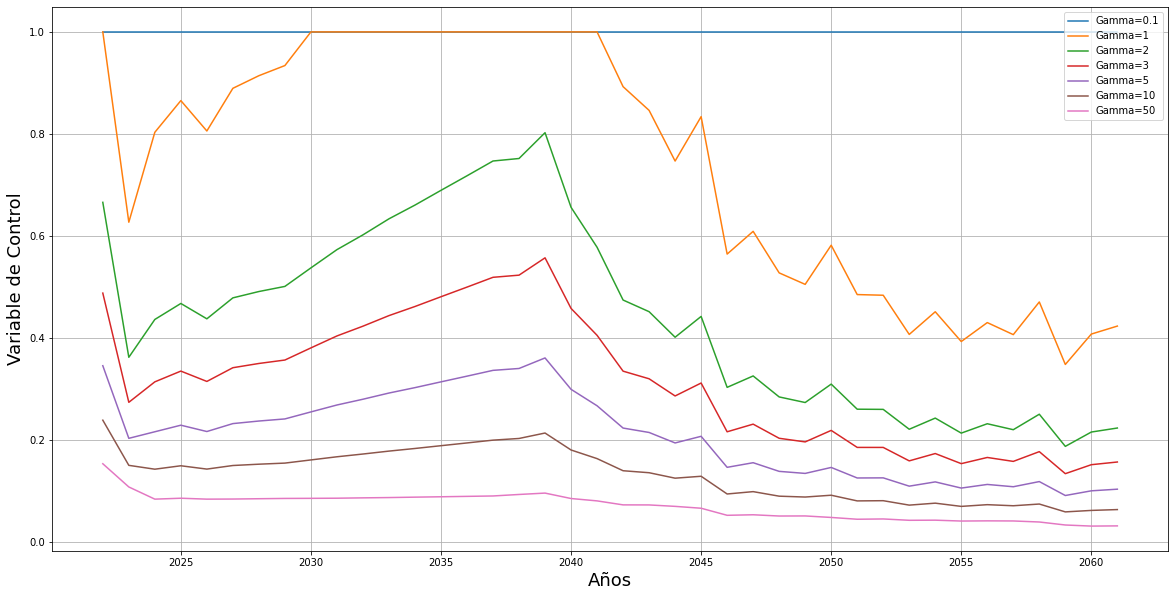

In [ ]:
plt.figure(figsize=(20,10))
cont=0
for gamma in lista:
  plt.plot([2022+i for i in range(40)],lista_x_vec[cont],label='Gamma=%s' % gamma)
  cont+=1
plt.legend(loc='upper right')
plt.xlabel("Años",fontsize=18)
plt.grid()
plt.ylabel("Variable de Control",fontsize=18)
plt.show()

In [ ]:
lista_f_vec=[]
for i in range(len(lista)):
  lista_f_vec.append(f_vec_array[41*i:41*(i+1)])

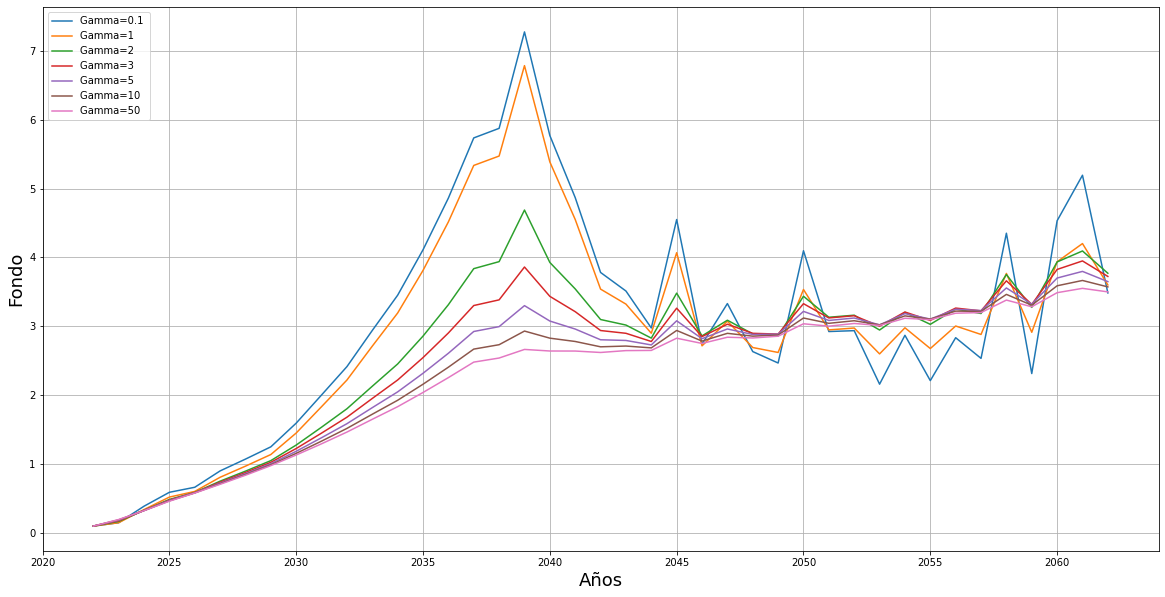

In [ ]:
plt.figure(figsize=(20,10))
j=0
plt.grid()
for gamma in lista:
  plt.plot([2022+i for i in range(41)],lista_f_vec[j],label='Gamma=%s ' % gamma)
  j+=1
plt.legend(loc='upper left')
plt.xlabel("Años",fontsize=18)
plt.ylabel("Fondo",fontsize=18)
plt.show()

Replacement rate

In [ ]:
años_jubilacion=18
meses=12
df=pd.DataFrame({'Gamma':lista,'RR':[(lista_f_vec[i][40]/(años_jubilacion)) for i in range(len(lista))]})
df

,Gamma,RR
0,0.1,0.193622
1,1.0,0.200069
2,2.0,0.209511
3,3.0,0.206934
4,5.0,0.202749
5,10.0,0.198493
6,50.0,0.194470


VaR

In [ ]:
covarianza

array([[0.08361807, 0.00502248],
       [0.00502248, 0.00099692]])

In [ ]:
lista_x_vec

[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.]),
 array([1.        , 0.626629  , 0.80305312, 0.86521978, 0.80561169,
        0.88933409, 0.91409072, 0.93399335, 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        0.89259059, 0.84602869, 0.74660913, 0.8337674 , 0.56410486,
        0.60870914, 0.52722126, 0.50466706, 0.58149456, 0.48466386,
        0.48335462, 0.40647396, 0.45092842, 0.39254907, 0.42970063,
        0.40605042, 0.47018729, 0.34754756, 0.40717344, 0.42283639]),
 array([0.66563457, 0.36161427, 0.43583102, 0.4671949 , 0.43708168,
        0.4781951 , 0.4906313 , 0.50066947, 0.53703495, 0.57280057,
        0.60180665, 0.63326751, 0.66022539, 0.68916735, 0.71769663,
        0.74672295, 0.75163067, 0.80226128, 0.65584676, 0.577508

In [ ]:
from scipy.stats import norm
cont=0
var_list=[]
for gamma in lista:
  weights=np.array([lista_x_vec[cont].mean(),1-lista_x_vec[cont].mean()])
  avg_rets=pd.DataFrame({'Fondo A':np.exp(fondo_a.mean()),'Fondo E':np.exp(fondo_e.mean())},index=[0])
  port_mean = avg_rets.dot(weights)

  # Calculate portfolio standard deviation
  port_stdev = np.sqrt(weights.T.dot(covarianza).dot(weights))
  initial_investment=lista_f_vec[cont][0]
  mean_investment = (1+port_mean) * initial_investment

  # Calculate standard deviation of investmnet
  stdev_investment = initial_investment * port_stdev
  # Select our confidence interval (I'll choose 95% here)
  conf_level1 = 0.05

  # Using SciPy ppf method to generate values for the
  # inverse cumulative distribution function to a normal distribution
  # Plugging in the mean, standard deviation of our portfolio
  # as calculated above
  # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
  cutoff1 = norm.ppf(1-conf_level1, mean_investment, stdev_investment)
  #Finally, we can calculate the VaR at our confidence interval
  var_1d1 = cutoff1
  var_list.append(var_1d1)
  cont+=1
var_list

[array([0.24897412]),
 array([0.23711628]),
 array([0.22337612]),
 array([0.21761823]),
 array([0.21311649]),
 array([0.20988632]),
 array([0.20751753])]

In [ ]:
mean_investment

0    0.200327
dtype: float64

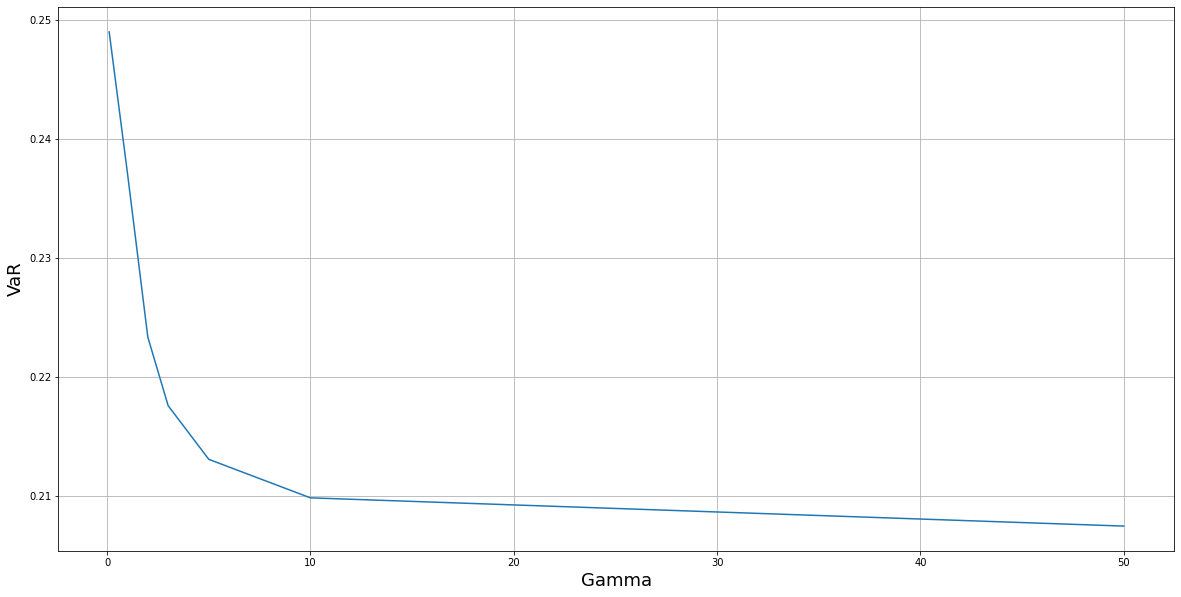

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(lista,var_list)
plt.grid()
plt.xlabel("Gamma",fontsize=18)
plt.ylabel("VaR",fontsize=18)
plt.show()

In [ ]:
años_jubilacion=18
df=pd.DataFrame({'Gamma':lista,'VaR':[x[0] for x in var_list]})
df

,Gamma,VaR
0,0.1,0.248974
1,1.0,0.237116
2,2.0,0.223376
3,3.0,0.217618
4,5.0,0.213116
5,10.0,0.209886
6,50.0,0.207518


CVaR

In [ ]:
cvar_list=[]
cont=0
for gamma in lista:
  CVaR = (1/(1-0.95))*norm.expect(lambda x: var_list[cont], lb = 0,ub=1-0.95)
  cvar_list.append(CVaR)
  cont+=1

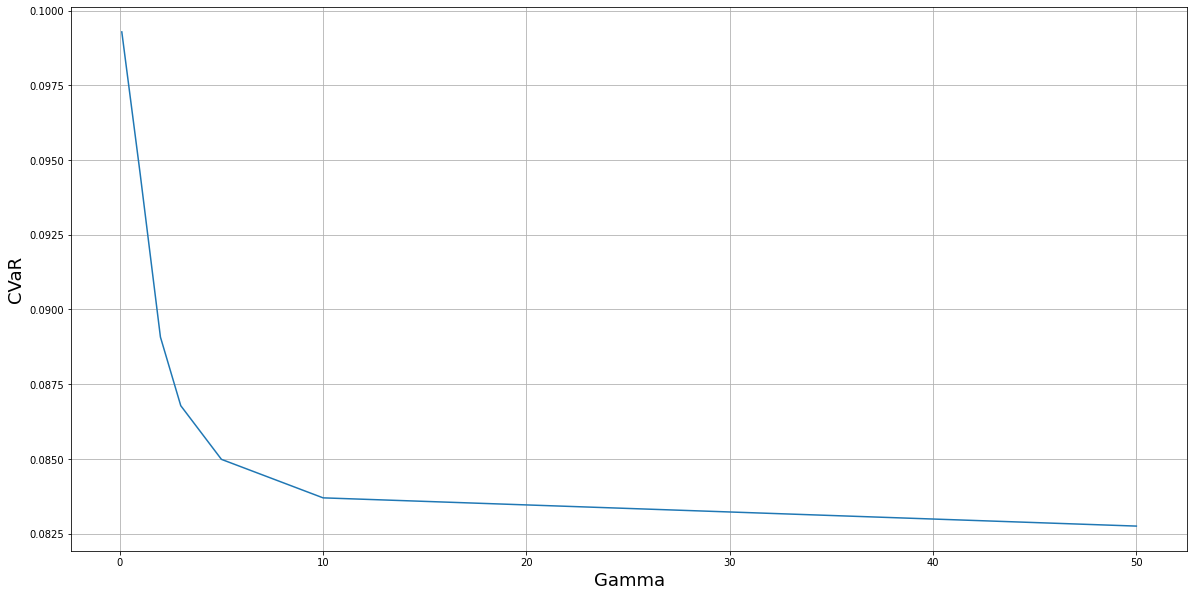

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(lista,cvar_list)
plt.grid()
plt.xlabel("Gamma",fontsize=18)
plt.ylabel("CVaR",fontsize=18)
plt.show()

<Figure size 1440x720 with 0 Axes>

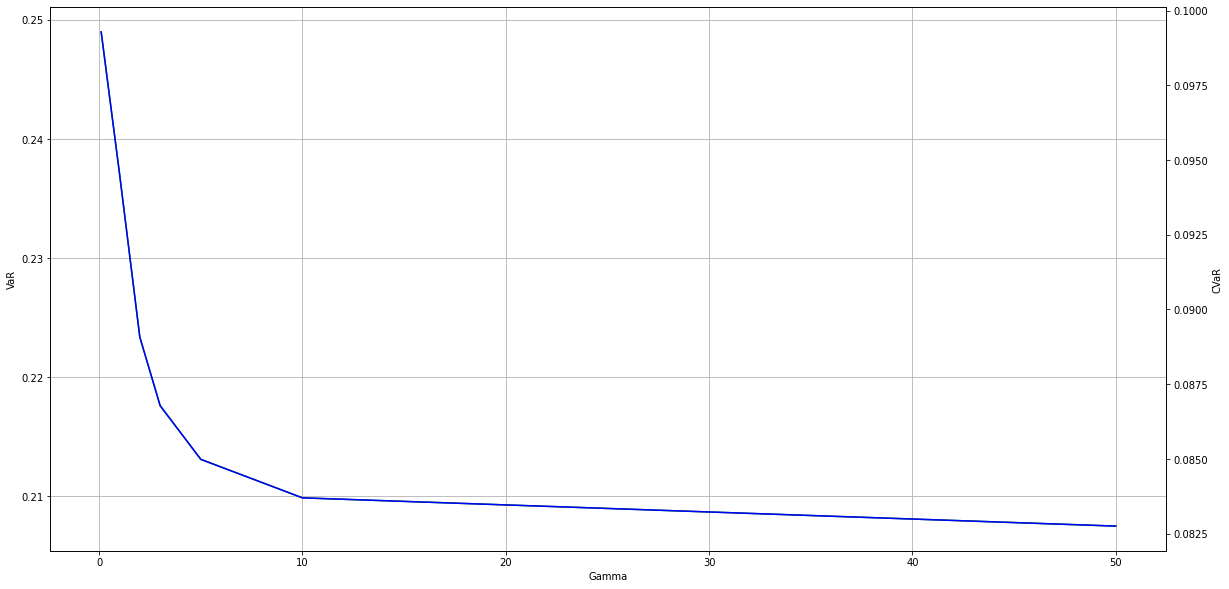

In [ ]:
plt.figure(figsize=(20,10))
fig, ax1 = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
ax1.grid()
ax2 = ax1.twinx()
ax1.plot(lista, var_list, 'g-')
ax2.plot(lista, cvar_list, 'b-')
ax1.set_ylabel('VaR')
ax2.set_ylabel('CVaR')
ax1.set_xlabel('Gamma')

#plt.grid()
#plt.xlabel("Gamma",fontsize=18)
#plt.ylabel("VaR",fontsize=18)
plt.show()

In [ ]:
df=pd.DataFrame({'Gamma':lista,'CVaR':cvar_list})
df

,Gamma,CVaR
0,0.1,0.099285
1,1.0,0.094556
2,2.0,0.089077
3,3.0,0.086781
4,5.0,0.084986
5,10.0,0.083698
6,50.0,0.082753


Laguna de de 6 meses cada 5 años


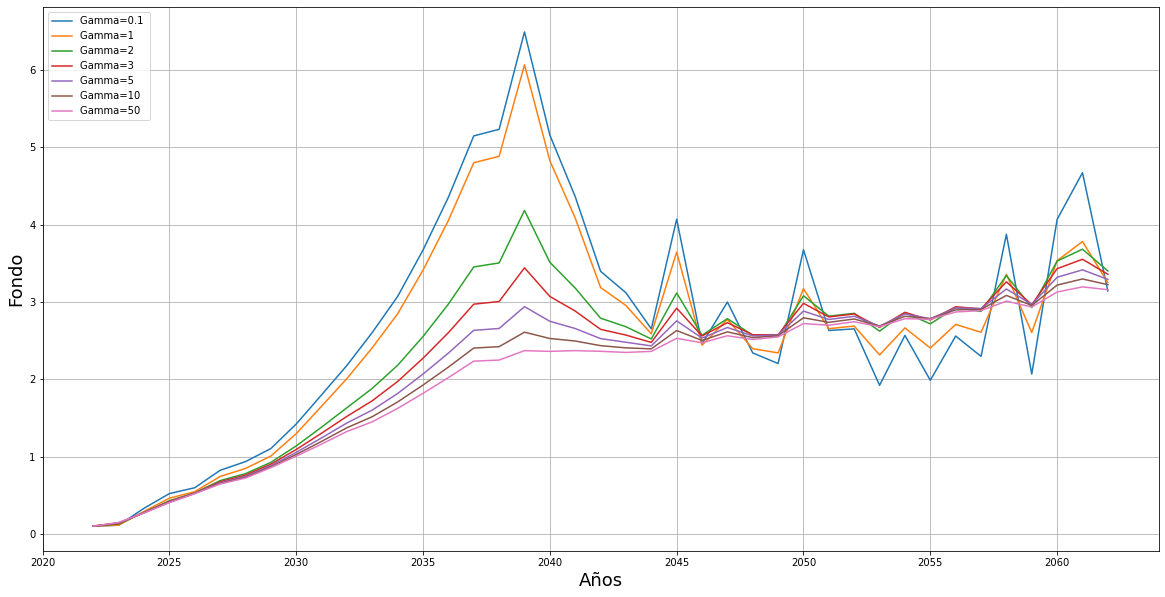

In [ ]:
f=np.zeros(41)
c=0.1
meses=12
f[0]=c
plt.figure(figsize=(20,10))
f_vec=[]
f_vec_array=np.array([])
j=0
for gamma in lista:
  for i in range(40):
      if i%5==0:
        lambda_A_t=fondo_a.loc[i]
        mu_E_t=fondo_e.loc[i]
        f[i+1]=(f[i]+c/2)*(lista_x_vec[j][i]*np.exp(lambda_A_t)+(1-lista_x_vec[j][i])*np.exp(mu_E_t))

      else:
        lambda_A_t=fondo_a.loc[i]
        mu_E_t=fondo_e.loc[i]
        f[i+1]=(f[i]+c)*(lista_x_vec[j][i]*np.exp(lambda_A_t)+(1-lista_x_vec[j][i])*np.exp(mu_E_t))
  f_vec.append(f)
  f_vec_array=np.append(f_vec_array,f)
  plt.plot([2022+i for i in range(41)],f_vec[j],label='Gamma=%s ' % gamma)
  j+=1
plt.legend(loc='upper left')
plt.grid()
plt.xlabel("Años",fontsize=18)
plt.ylabel("Fondo",fontsize=18)
plt.show()

In [ ]:
lista_f_vec=[]
for i in range(len(lista)):
  lista_f_vec.append(f_vec_array[41*i:41*(i+1)])

Tasa de reemplazo


In [ ]:
años_jubilacion=18
df=pd.DataFrame({'Gamma':lista,'RR':[(lista_f_vec[i][40]/(años_jubilacion)) for i in range(len(lista))]})
df

,Gamma,RR
0,0.1,0.174465
1,1.0,0.180460
2,2.0,0.188856
3,3.0,0.186528
4,5.0,0.182788
5,10.0,0.178996
6,50.0,0.175415


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
lista_RR=[]
x_solucion=np.ones(40)
alpha=np.exp(0.005)
años_jubilacion=18
f=np.zeros(41)
sueldo=1
c=0.1
f[0]=0.1
x_vec=np.array([])
plt.figure(figsize=(20,10))
offset=19
f_vec_array=np.array([])
for j in range(100):
  print(j)
  periodos=40
  sueldo=1
  gamma=2
  fondo_a=pd.read_csv('/content/drive/My Drive/Escenarios Fondo A/df_escenario_'+str(j)+'.csv')[['Fondo Tipo A']]
  fondo_e=pd.read_csv('/content/drive/My Drive/Escenarios Fondo E/df_escenario_'+str(j)+'.csv')[['Fondo Tipo A']]
  fondo_a_historico=pd.read_csv("/content/drive/My Drive/Agrupacion_historica_Fondo_A.csv")[['Fondo Tipo A']]
  fondo_e_historico=pd.read_csv("/content/drive/My Drive/Agrupacion_historica_Fondo_E.csv")[['Fondo Tipo E']]
  fondo_e.columns=['Fondo Tipo E']
  fondo_a_mean=float(fondo_a.mean())
  fondo_e_mean=float(fondo_e.mean())
  periodos=40
  lambda_= fondo_a.values
  mu_= fondo_e.values
  fondo_a_new=pd.DataFrame(fondo_a,columns=['Fondo Tipo A'])
  fondo_e_new=pd.DataFrame(fondo_e,columns=['Fondo Tipo E'])
  fondo_a_historico=pd.concat([fondo_a_historico,fondo_a_new],axis=0)
  fondo_e_historico=pd.concat([fondo_e_historico,fondo_e_new],axis=0)
  fondo_a_historico=fondo_a_historico.reset_index().drop(columns=['index'])
  fondo_e_historico=fondo_e_historico.reset_index().drop(columns=['index'])
  fondo_a=fondo_a_historico['Fondo Tipo A']
  fondo_e=fondo_e_historico['Fondo Tipo E']
  covarianza = np.cov(np.stack((fondo_a.values,fondo_e.values),axis=0))
  for i in range(40):
      m = Model('ALM')
      x = m.addVar(lb=0,ub=1,vtype=GRB.CONTINUOUS)
      #c=f[i]*0.1
      lambda_A_t=fondo_a.loc[:i+offset].mean()#probar i-1
      sigma_A_t=fondo_a.loc[:i+offset].var()
      mu_E_t=fondo_e.loc[:i+offset].mean()
      sigma_E_t=fondo_e.loc[:i+offset].var()
      m.addConstr(x*(np.exp(lambda_A_t+sigma_A_t/2))+(1-x)*(np.exp(mu_E_t+sigma_E_t/2))>=alpha)
      m.setObjective(x*float(np.exp(lambda_A_t+sigma_A_t/2))+(1-x)*float(np.exp(mu_E_t+sigma_E_t/2))-gamma*(x*x*float(((np.exp(sigma_A_t)-1))*np.exp(2*lambda_A_t+sigma_A_t))+(1-x)*(1-x)*float((np.exp(sigma_E_t)-1)*np.exp(2*mu_E_t+sigma_E_t))+2*x*(1-x)*float(np.exp((mu_E_t+lambda_A_t)+(sigma_A_t+sigma_E_t)/2)*(np.exp(np.sqrt(sigma_A_t)*np.sqrt(sigma_E_t)*covarianza[1][0])-1))),GRB.MAXIMIZE)
      m.optimize()
      x_solucion[i]=x.x
      f[i+1]=(f[i]+c)*(x_solucion[i]*np.exp(lambda_[i])+(1-x_solucion[i])*np.exp(mu_[i]))
  f_vec_array=np.append(f_vec_array,f)
  x_vec=np.append(x_vec,np.array([[x_solucion]]))

Se han truncado las últimas 5000 líneas del flujo de salida.
Barrier solved model in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective 1.04793428e+00
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 1 rows, 1 columns and 1 nonzeros
Model fingerprint: 0x3084ccdd
Model has 1 quadratic objective term
Coefficient statistics:
  Matrix range     [1e-02, 1e-02]
  Objective range  [2e-02, 2e-02]
  QObjective range [3e-02, 3e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-02, 4e-02]
Presolve removed 1 rows and 1 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Barrier solved model in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective 1.04697097e+00
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz,

<Figure size 1440x720 with 0 Axes>

In [ ]:
f_vec_array.shape

(4100,)

In [ ]:
lista_f_vec=[]
lista_RR=[]
for i in range(100):
  lista_f_vec.append(f_vec_array[41*i:41*(i+1)])
for i in range(100):
  lista_RR.append((lista_f_vec[i][40]/(años_jubilacion)))

In [ ]:
np.median(lista_RR)

0.702098631406485

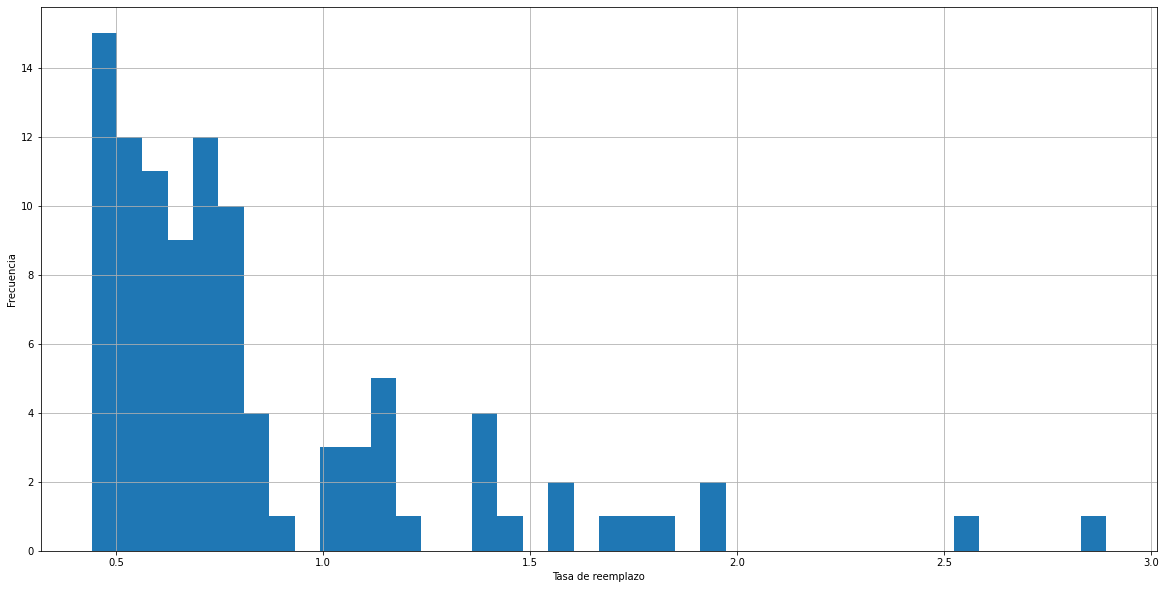

In [ ]:
plt.figure(figsize=(20,10))
plt.hist(lista_RR,bins=40)
plt.grid()
plt.ylabel('Frecuencia')
plt.xlabel('Tasa de reemplazo')
plt.show()